In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [5]:
OUTPUT_DIR = os.path.join('..', 'models', 'timit-xlsr-finetune-B')
PRE_TRAINED_ID = "ginic/data_seed_4_wav2vec2-large-xlsr-buckeye-ipa"

# Load Data

In [6]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [7]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [8]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [9]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        '͡': '', # Simplify affricate to single character
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔittʃɹɹeɪznzaʊtɔɹzɔnəpɔɹttʃstɛps,"[0, 2250, 2725, 3520, 4000, 5389, 6224, 6976, ...","[2250, 2725, 3520, 4000, 5389, 6224, 6976, 977..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",itnaʊʃilʊkʔʌɡli,"[0, 2120, 2327, 2860, 3456, 4840, 7564, 9725, ...","[2120, 2327, 2860, 3456, 4840, 7564, 9725, 105..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksuɾinɡɹisiwɔʃwɔɾɹɔljiɹ,"[0, 2339, 3960, 5138, 6224, 8062, 8550, 9024, ...","[2339, 3960, 5138, 6224, 8062, 8550, 9024, 960..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",wʌnmɔɹmʌɾlhɛɾɪdleɪlaɪkðæwʌnɪnðeɪdiliɾiŋhɪməweɪ,"[0, 4804, 5514, 6934, 7644, 8522, 10227, 11080...","[4804, 5514, 6934, 7644, 8522, 10227, 11080, 1..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðiʔɛmpɹihæɾimintɛmpɹ,"[0, 2231, 2834, 3757, 5045, 6023, 6825, 7070, ...","[2231, 2834, 3757, 5045, 6023, 6825, 7070, 795..."


### Cleaning Up Audio

In [10]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

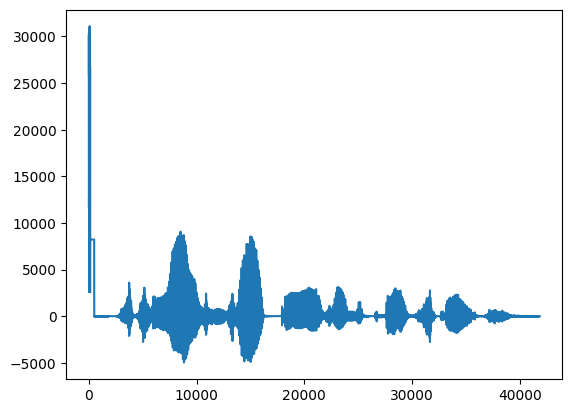

In [11]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [12]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔittʃɹɹeɪznzaʊtɔɹzɔnəpɔɹttʃstɛps,"[0, 2250, 2725, 3520, 4000, 5389, 6224, 6976, ...","[2250, 2725, 3520, 4000, 5389, 6224, 6976, 977...","[5, 3, 4, 5, 1, 3, 1, 5, 4, 7, 4, 5, 5, 0, 8, ..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",itnaʊʃilʊkʔʌɡli,"[0, 2120, 2327, 2860, 3456, 4840, 7564, 9725, ...","[2120, 2327, 2860, 3456, 4840, 7564, 9725, 105...","[5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksuɾinɡɹisiwɔʃwɔɾɹɔljiɹ,"[0, 2339, 3960, 5138, 6224, 8062, 8550, 9024, ...","[2339, 3960, 5138, 6224, 8062, 8550, 9024, 960...","[3, 5, 2, 5, 4, 7, 6, 4, 3, 3, 1, 0, 1, 2, -1,..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",wʌnmɔɹmʌɾlhɛɾɪdleɪlaɪkðæwʌnɪnðeɪdiliɾiŋhɪməweɪ,"[0, 4804, 5514, 6934, 7644, 8522, 10227, 11080...","[4804, 5514, 6934, 7644, 8522, 10227, 11080, 1...","[4, 4, 5, 1, 4, 3, 2, 1, 0, 0, -1, -1, -1, -4,..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðiʔɛmpɹihæɾimintɛmpɹ,"[0, 2231, 2834, 3757, 5045, 6023, 6825, 7070, ...","[2231, 2834, 3757, 5045, 6023, 6825, 7070, 795...","[5, 4, 3, 6, 3, 2, 5, 5, 4, 2, 6, 1, 6, 2, 3, ..."


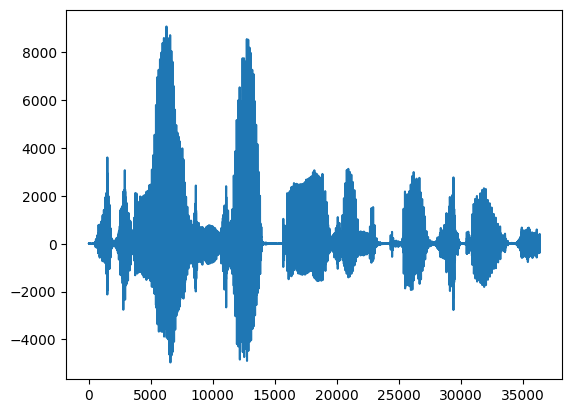

In [13]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [14]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,ʔittʃɹɹeɪznzaʊtɔɹzɔnəpɔɹttʃstɛps,"[5, 3, 4, 5, 1, 3, 1, 5, 4, 7, 4, 5, 5, 0, 8, ..."
1,itnaʊʃilʊkʔʌɡli,"[5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, ..."
2,ʃihædjɹdɑɹksuɾinɡɹisiwɔʃwɔɾɹɔljiɹ,"[3, 5, 2, 5, 4, 7, 6, 4, 3, 3, 1, 0, 1, 2, -1,..."
3,wʌnmɔɹmʌɾlhɛɾɪdleɪlaɪkðæwʌnɪnðeɪdiliɾiŋhɪməweɪ,"[4, 4, 5, 1, 4, 3, 2, 1, 0, 0, -1, -1, -1, -4,..."
4,ðiʔɛmpɹihæɾimintɛmpɹ,"[5, 4, 3, 6, 3, 2, 5, 5, 4, 2, 6, 1, 6, 2, 3, ..."


In [15]:
train_ds = Dataset.from_pandas(train_df)

# Extend Phoneme Vocab

In [16]:
timit_vocab = set("".join(train_df['ipa']))

In [17]:
print(timit_vocab)

{'ʒ', 's', 'ŋ', 'ʌ', 'æ', 'i', 'j', 'k', 'θ', 'p', 'ð', 'b', 'ʔ', 't', 'm', 'ɛ', 'ɑ', 'e', 'd', 'ə', 'z', 'f', 'v', 'ʃ', 'ɔ', 'l', 'ʊ', 'h', 'ɪ', 'ɹ', 'u', 'a', 'w', 'ɡ', 'n', 'o', 'ɾ'}


In [18]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'A': 113, 'C': 20, 'E': 89, 'H': 148, 'I': 124, 'O': 28, 'U': 176, 'X': 224, '[PAD]': 312, '[UNK]': 311, '_': 259, 'a': 156, 'ã': 188, 'b': 286, 'b̪': 83, 'b̪͡v': 137, 'b͡ꞵ': 80, 'c': 186, 'cʼ': 277, 'c͡ç': 265, 'd': 229, 'd̼': 210, 'd͡z': 51, 'd͡ð': 110, 'd͡ɮ': 284, 'd͡ʑ': 112, 'd͡ʒ': 214, 'e': 22, 'ẽ': 233, 'e̞': 202, 'ẽ̞': 187, 'f': 34, 'fʼ': 181, 'h': 253, 'i': 160, 'j': 92, 'k': 135, 'kxʼ': 221, 'kǀ': 25, 'kǁ': 140, 'kǂ': 115, 'kǃ': 97, 'kʘ': 165, 'kʼ': 7, 'k̚': 118, 'k͡p': 102, 'k͡x': 287, 'l': 292, 'm': 85, 'm̥': 101, 'n': 141, 'n̥': 54, 'n̼': 61, 'o': 162, 'õ': 62, 'o̞': 203, 'õ̞': 60, 'p': 38, 'pʼ': 216, 'p̚': 11, 'p̪': 236, 'p̪͡f': 205, 'p͡f': 43, 'p͡ɸ': 154, 'q': 237, 'qǀ': 9, 'qǁ': 49, 'qǂ': 196, 'qǃ': 53, 'qʘ': 119, 'qʼ': 99, 'q͡ʡ': 169, 'q͡χʼ': 44, 'q͡ꭓ': 226, 'r': 254, 'r̥': 174, 's': 201, 'sʼ': 117, 't': 39, 'tʼ': 2, 't̚': 59, 't̪͡θʼ': 50, 't̼': 307, 't͡s': 264, 't͡sʼ': 68, 't͡ɕ': 281, 't͡ɬ': 158, 't͡ɬʼ': 172, 't͡ʃ': 246, 't͡ʃʼ': 192, 't͡θ': 161, 'u': 48, 'ũ': 15

In [19]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
tokenizer.add_tokens(list(additional_vocab))
print(additional_vocab)


set()


# Update Feature Extraction

In [20]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

### NEW FINE-TUNE CODE


In [35]:
import torch
import tempfile
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, Wav2Vec2CTCTokenizer
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import logging
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.model_selection import train_test_split
import torchaudio
import json

#B1- LESS TRAINING EPOCHS
#B2- LENGTH PENALTY 
#B3- MORE TRAINING EPOCHS

NEW_MODEL_ID = "./notebooks/results-b3"

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Add max length check
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH  # Your existing constant
        )
        # Pad input_values
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            # Convert to tensor and ensure correct shape
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            # Remove any extra dimensions and ensure it's 1D
            input_values = input_values.squeeze()
            
            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        # Stack all padded inputs ensuring correct dimensions [batch_size, sequence_length]
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # Process labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch
def prepare_model_and_processor(timit_vocab):
    """
    Prepare the model and processor with reduced vocabulary and consistent special token IDs.
    """
    logger.info("Loading pretrained model and processor...")
    
    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
    
    # Store the old vocabulary before making any changes
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    # Define fixed special token IDs - pad token first for CTC
    special_tokens = {
        "<pad>": 0,  # Changed to 0 for CTC blank token
        "<s>": 1,    # Shifted up
        "</s>": 2,   # Shifted up
        "<unk>": 3   # Shifted up
    }
    logger.info("Initial special tokens setup:")
    for token, idx in special_tokens.items():
        logger.info(f"{token}: {idx}")
    
    # Get regular tokens (excluding special tokens)
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))
    
    # Create combined vocabulary with fixed IDs
    vocab = {**special_tokens}  # Start with special tokens
    
    # Add regular tokens after special tokens
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    # Create tokenizer config with consistent token formats
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }
    
    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    # Create new tokenizer
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    # Verify tokenizer loaded correctly before proceeding
    loaded_vocab = new_tokenizer.get_vocab()
    logger.info("\nVerifying special token IDs in new tokenizer:")
    for token, expected_id in special_tokens.items():
        actual_id = loaded_vocab.get(token)
        logger.info(f"{token}: expected={expected_id}, actual={actual_id}")
        assert actual_id == expected_id, f"Token ID mismatch for {token}"
    
    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)
    
    # Verify vocab size
    final_vocab_size = len(processor.tokenizer.get_vocab())
    logger.info(f"\nFinal vocabulary size: {final_vocab_size}")
    assert final_vocab_size == len(vocab), "Vocabulary size mismatch"
    
    # Handle model weights
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    # Create new layer
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    new_layer.weight.data.zero_()
    new_layer.bias.data.zero_()
    
    # Transfer weights and bias using the stored old_vocab
    for token, new_idx in loaded_vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
    
    model.lm_head = new_layer
    model.config.vocab_size = final_vocab_size
    model.config.pad_token_id = 0  # Explicitly set pad token as CTC blank token
    
    # Final verification
    logger.info("\nFinal vocabulary check:")
    final_vocab = processor.tokenizer.get_vocab()
    for token, expected_id in special_tokens.items():
        actual_id = final_vocab.get(token)
        logger.info(f"{token}: {actual_id}")
        assert actual_id == expected_id, f"Final token ID mismatch for {token}"
    
    return model, processor


def preprocess_audio(audio_input):
    """
    Load and preprocess audio to match expected format.
    
    Args:
        audio_input: Can be a file path (str), numpy array, list, or tensor
        
    Returns:
        np.ndarray: Processed audio as float32 numpy array
    """
    # Handle different input types
    if isinstance(audio_input, str):  # File path
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
        
    elif isinstance(audio_input, list):  # List input
        audio_numpy = np.array(audio_input, dtype=np.float32)
        
    elif isinstance(audio_input, np.ndarray):  # Already numpy array
        audio_numpy = audio_input
        
    elif isinstance(audio_input, torch.Tensor):  # Torch tensor
        audio_numpy = audio_input.numpy()
        
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    # Ensure float32 dtype
    audio_numpy = audio_numpy.astype(np.float32)
    
    # Ensure 1D array
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    # Normalize audio
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    # Trim or pad to max length
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def prepare_datasets(train_df, processor):
    """
    Split and prepare datasets for training and evaluation.
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        
        # Ensure audio is 1D
        audio = audio.squeeze()
        
        # Process audio with the processor
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None,
            padding=False
        )
        
        # Ensure input_values is 1D
        input_values = np.squeeze(inputs["input_values"])
        
        # Tokenize IPA
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio  # Keep the audio in the processed data
        }
    
    # Convert DataFrames to Datasets
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing
    train_dataset = train_dataset.map(
        process_data,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]  # Keep audio column
    )
    eval_dataset = eval_dataset.map(
        process_data,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]  # Keep audio column
    )
    
    # Debug: Check shapes
    sample_item = train_dataset[0]
    logger.info(f"Sample input_values shape: {np.array(sample_item['input_values']).shape}")
    logger.info(f"Sample labels shape: {np.array(sample_item['labels']).shape}")
    
    return train_dataset, eval_dataset

def verify_dimensions(batch, logger):
    """
    Debug helper to verify tensor dimensions
    """
    logger.info("Batch dimensions:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            logger.info(f"{key}: {value.shape}")

# def train_model(model, train_dataset, eval_dataset, processor, output_dir="./results"):
    # """
    # Train the model using CTC loss.
    # """
    # logger.info("Starting training...")
    
    # # training_args = TrainingArguments(
    # #     output_dir=output_dir,
    # #     per_device_train_batch_size=1,
    # #     gradient_accumulation_steps=4,
    # #     learning_rate=1e-4,
    # #     num_train_epochs=3,
    # #     logging_dir='./logs',
    # #     logging_steps=10,
    # #     # Increase save_steps to reduce disk usage
    # #     save_steps=500,  # Changed from 100
    # #     eval_steps=100,
    # #     eval_strategy="steps",
    # #     load_best_model_at_end=True,
    # #     # Add save_safetensors=True for more reliable saving
    # #     save_safetensors=True,
    # # )
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     # Decrease learning rate since loss is high
    #     learning_rate=1e-5,  # Changed from 1e-4
        
    #     # Increase batch size for better stability
    #     per_device_train_batch_size=1,  # Changed from 1
    #     gradient_accumulation_steps=4,   # Changed from 4 (maintains effective batch size of 16)
        
    #     # Add warmup steps
    #     warmup_steps=500,
        
    #     # Add weight decay for regularization
    #     weight_decay=0.01,
        
    #     # Increase training time
    #     num_train_epochs=10,  # Changed from 3
        
    #     # Keep other parameters
    #     logging_dir='./logs',
    #     logging_steps=10,
    #     save_steps=500,
    #     eval_steps=100,
    #     eval_strategy="steps",
    #     load_best_model_at_end=True,

        
    #     # Add early stopping
    #     metric_for_best_model="eval_loss",
    #     greater_is_better=False,

    #     # Add these parameters for more robust checkpointing
    #     save_safetensors=True,
    #     save_strategy="steps",
    #     save_total_limit=3,  # Keep only last 3 checkpoints to manage disk space
        
    #     # Add this to handle potential corruption
    #     hub_strategy="end",  # Only save to hub at end of training
    # )
    # data_collator = DataCollatorCTCWithPadding(processor=processor)
    
    # trainer = Trainer(
    #     model=model,
    #     args=training_args,
    #     train_dataset=train_dataset,
    #     eval_dataset=eval_dataset,  # Include the eval dataset here
    #     data_collator=data_collator,
    # )
    
    # # Train the model
    # trainer.train(resume_from_checkpoint="./results/checkpoint-3100")

    # # Save the final model and processor
    # model.save_pretrained(output_dir)
    # processor.save_pretrained(output_dir)
    
    # return model, processor

def verify_token_ids(processor, stage=""):
    """
    Simple token verification function
    """
    logger.info(f"\n=== Token ID Verification [{stage}] ===")
    vocab = processor.tokenizer.get_vocab()
    logger.info(f"Vocabulary size: {len(vocab)}")
    
    # Check special tokens
    special_tokens = ["<pad>", "<s>", "</s>", "<unk>"]
    for token in special_tokens:
        token_id = vocab.get(token)
        logger.info(f"Token {token}: ID {token_id}")
    
    # Sample a few regular tokens
    regular_tokens = [t for t in list(vocab.keys())[:5] if t not in special_tokens]
    logger.info("Sample regular token IDs:")
    for token in regular_tokens:
        logger.info(f"Token {token}: ID {vocab[token]}")
    
    return vocab

def main(train_df, timit_vocab):
    """
    Main training pipeline.
    """
    # Initialize wandb for tracking
    wandb.init(project="xlsr-buckeye-phoneme-prediction")
    
    # Prepare model and processor
    model, processor = prepare_model_and_processor(timit_vocab)
    
    # Verify tokens after preparation
    vocab = verify_token_ids(processor, "After Model Preparation")
    logger.info(f"Full vocabulary: {vocab}")
    
    # Get the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Ensure model is on GPU
    
    # Prepare train and eval datasets
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    
    # Create trainer
    training_args = TrainingArguments(
        output_dir="./results-b3",
        learning_rate=1e-4,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4, 
        warmup_steps=500,
        weight_decay=0.001,
        num_train_epochs=5,
        logging_dir='./logs',
        logging_steps=10,
        save_steps=500,
        eval_steps=100,
        eval_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=5,
        hub_strategy="end",
    )
    
    data_collator = DataCollatorCTCWithPadding(processor=processor)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )
    
    # Train model
    trainer.train(resume_from_checkpoint="./results-b3/checkpoint-1000") # resume_from_checkpoint="./results-b1/checkpoint-500"
    
    # Save the final model and processor
    model.save_pretrained("./results-b3")
    processor.save_pretrained("./results-b3")
    
    # Verify tokens after training
    verify_token_ids(processor, "After Training")
    
    # Final inference verification
    logger.info("Running inference on sample...")
    sample_audio = train_dataset[0]["audio"]
    inputs = processor(sample_audio, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    
    predicted_tokens = processor.batch_decode(predicted_ids)
    cleaned_prediction = (predicted_tokens[0]
                        .replace('<s>', '')
                        .replace('</s>', '')
                        .replace('<pad>', '')
                        .replace('<unk>', '')
                        .strip())
    
    logger.info(f"Sample raw prediction: {predicted_tokens}")
    logger.info(f"Sample cleaned prediction: {cleaned_prediction}")
    
    wandb.finish()

if __name__ == "__main__":
    main(train_df, timit_vocab)

INFO:__main__:Loading pretrained model and processor...
INFO:__main__:Initial vocabulary size: 315
INFO:__main__:Initial special tokens setup:
INFO:__main__:<pad>: 0
INFO:__main__:<s>: 1
INFO:__main__:</s>: 2
INFO:__main__:<unk>: 3
INFO:__main__:
Verifying special token IDs in new tokenizer:
INFO:__main__:<pad>: expected=0, actual=0
INFO:__main__:<s>: expected=1, actual=1
INFO:__main__:</s>: expected=2, actual=2
INFO:__main__:<unk>: expected=3, actual=3
INFO:__main__:
Final vocabulary size: 41
INFO:__main__:
Final vocabulary check:
INFO:__main__:<pad>: 0
INFO:__main__:<s>: 1
INFO:__main__:</s>: 2
INFO:__main__:<unk>: 3
INFO:__main__:
=== Token ID Verification [After Model Preparation] ===
INFO:__main__:Vocabulary size: 41
INFO:__main__:Token <pad>: ID 0
INFO:__main__:Token <s>: ID 1
INFO:__main__:Token </s>: ID 2
INFO:__main__:Token <unk>: ID 3
INFO:__main__:Sample regular token IDs:
INFO:__main__:Token a: ID 4
INFO:__main__:Full vocabulary: {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3

Step,Training Loss,Validation Loss
1100,18.311100,4.981781


INFO:__main__:
=== Token ID Verification [After Training] ===
INFO:__main__:Vocabulary size: 41
INFO:__main__:Token <pad>: ID 0
INFO:__main__:Token <s>: ID 1
INFO:__main__:Token </s>: ID 2
INFO:__main__:Token <unk>: ID 3
INFO:__main__:Sample regular token IDs:
INFO:__main__:Token a: ID 4
INFO:__main__:Running inference on sample...
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
INFO:__main__:Sample raw prediction: ['ðisɹdʒinkɛɹiɾikdʒivlaɪɪɪɪɪ']
INFO:__main__:Sample cleaned prediction: ðisɹdʒinkɛɹiɾikdʒivlaɪɪɪɪɪ


eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▁▃▅▁█▁▁▃▂▄▃▅▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▂▂▁▁
train/loss,▄▁▇▇▅▃▃▂█▆▂▄▃▄▄
eval/loss,4.98178
eval/runtime,100.6571


# Preprocess Data

In [48]:
processor = AutoProcessor.from_pretrained("/home/arunasrivastava/ML/notebooks/results")
print(f"processor vocab: {processor.tokenizer.get_vocab()}")

processor vocab: {'</s>': 1, '<pad>': 3, '<s>': 0, '<unk>': 2, 'a': 11, 'b': 14, 'd': 17, 'e': 22, 'f': 23, 'h': 31, 'i': 24, 'j': 35, 'k': 26, 'l': 38, 'm': 28, 'n': 20, 'o': 5, 'p': 13, 's': 9, 't': 32, 'u': 21, 'v': 37, 'w': 19, 'z': 7, 'æ': 16, 'ð': 29, 'ŋ': 33, 'ɑ': 40, 'ɔ': 15, 'ə': 12, 'ɛ': 30, 'ɡ': 39, 'ɪ': 10, 'ɹ': 8, 'ɾ': 34, 'ʃ': 18, 'ʊ': 36, 'ʌ': 6, 'ʒ': 25, 'ʔ': 4, 'θ': 27}


In [ ]:

vocab = processor.tokenizer.get_vocab()
print(vocab)

In [167]:
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio"], sampling_rate=feature_extractor.sampling_rate).input_values
    with processor.as_target_processor():
        batch["labels"] = processor(batch["ipa"]).input_ids
    print("Tokenized IPA:", batch['labels'])
    # convert the batch['labels'] back to IPA
    decoded_ipa = [processor.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
    print("Decoded IPA (skipping special tokens):", decoded_ipa)
    print("Length of tokenized IPA:", len(batch['labels']))
    return batch

In [ ]:
# test prepare_dataset on just the furst row of the train_ds

ds_test = prepare_dataset(train_ds[0])
print(ds_test)

In [ ]:
train_ds_prepared = train_ds.map(prepare_dataset, batch_size=8, num_proc=4)

In [ ]:
test_ds_prepared = test_ds.map(prepare_dataset, batch_size=8, num_proc=4)

In [ ]:
train_ds_prepared.to_pandas().head()

# Fine-Tune Model

In [ ]:
vocab = processor.tokenizer.get_vocab()
print(vocab)


In [ ]:
# print first row of train ipa
print(len(train_ds_prepared[0]['ipa']))
print(train_ds_prepared[0]['ipa'])
# print ipa mapped to the vocab numbers
print(train_ds_prepared[0]['labels'])

print(len(train_ds_prepared[0]['labels']))

In [152]:

class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    def __init__(self, processor: AutoProcessor, padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None):
        self.processor = processor
        self.padding = padding
        self.max_length = max_length
        self.max_length_labels = max_length_labels
        self.pad_to_multiple_of = pad_to_multiple_of
        self.pad_to_multiple_of_labels = pad_to_multiple_of_labels

    def __call__(self, features: "list[dict[str, list[int] | torch.Tensor]]") -> "dict[str, torch.Tensor]":
        vocab = processor.tokenizer.get_vocab()  # For most processors, this works
        print("MF VOCAB", vocab)

        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]


        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        print("input-features pt after processor.pad", batch["input_values"].shape)
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )
        print("labels-features pt after processor.pad", labels_batch["input_ids"].shape)
        # Loop through each sequence in the batch and decode
        for i, input_ids in enumerate(labels_batch["input_ids"]):
            decoded_text = processor.decode(input_ids.tolist(), skip_special_tokens=False)
            print(f"Decoded text for sample {i}: {decoded_text}")
     

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        print("labels: ", labels)
        print("labels-features pt after masked_fill", labels.shape)

        batch["labels"] = labels

        return batch

In [ ]:
# Assuming train_ds is your dataset
sample = train_ds_prepared[0]  # Grab the first row from the dataset
# print the first row's phonemes
print("Phonemes:", sample["ipa"])
# Create an instance of the DataCollatorCTCWithPadding class
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)  # Replace with your processor
data_collator = DataCollatorCTCWithPadding(processor=processor)

# Manually test the data collator with the sample
features = [sample]
batch = data_collator(features)

# Print the batch to inspect the results
print("Batch:", batch)

In [78]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [68]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [79]:

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False) # labels are already grouped as they should be

    # Call panphon_model_eval with label and predictedipa
    results = panphon_model_eval(label_str, pred_str)

    # Output results
    print("Evaluation Results:")
    print(f"Feature edit distance: {results['feature_dist']}")
    print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
    print(f"Hamming distance: {results['hamming_feature_dist']}")
    print(f"CER: {results['cer_score']}")


    return results

In [80]:
model = AutoModelForCTC.from_pretrained(
    PRE_TRAINED_ID, 
    pad_token_id=processor.tokenizer.pad_token_id, 
    # gradient_checkpointing=True,
    ctc_zero_infinity = True,
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

In [81]:
# model.resize_token_embeddings(len(tokenizer))
old_weights = model.lm_head.weight.t().detach()
old_bias = model.lm_head.bias.detach()
new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
new_layer.weight.data[:model.lm_head.out_features, :] = old_weights.t()
new_layer.bias.data[:model.lm_head.out_features] = old_bias
model.lm_head = new_layer
model.config.vocab_size = len(processor.tokenizer)

In [82]:
model.freeze_feature_encoder()

In [73]:
# sanity checks
max_class_id = 0
for label_sequence in train_ds_prepared['labels']:
    for class_id in label_sequence:
        max_class_id = max(max_class_id, class_id)
assert max_class_id == model.config.vocab_size - 1

for label_sequence in train_ds_prepared['labels']:
    for class_id in label_sequence:
        assert class_id >= 0 and class_id <  model.config.vocab_size

for label_sequence in train_ds_prepared['labels']:
    assert  len(label_sequence) < 1024
    assert len(label_sequence) >= 5

In [ ]:
import wandb
from transformers import TrainingArguments, Trainer

# Initialize wandb
wandb.init(project="timit-finetune-a100")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    eval_strategy="steps",
    num_train_epochs=5,
    fp16=True,
    save_steps=50,
    eval_steps=50,
    logging_steps=10,
    learning_rate=1e-5,
    warmup_steps=1000,
    save_total_limit=3,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    max_grad_norm=0.5,
    report_to="wandb" 
)

In [84]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds_prepared.select(range(10)),
    # train_dataset=train_ds_prepared,
    eval_dataset=test_ds_prepared.select(range(10)),
    # eval_dataset=test_ds_prepared,
    processing_class=processor.feature_extractor,
)

In [ ]:
# torch.autograd.set_detect_anomaly(False) # debug NaNs, disable for real training to improve performance
# model.config.ctc_zero_infinity = True 
#resume_from_checkpoint=True
trainer.train() # resume_from_checkpoint=True to resume training if training was interrupted

# Evaluate

In [ ]:
import wandb
eval_results = trainer.evaluate()
wandb.log(eval_results)

In [44]:
old_model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID).to(model.device)

In [45]:
finetuned_model = AutoModelForCTC.from_pretrained(os.path.join(OUTPUT_DIR, 'checkpoint-100'))

In [46]:
# check for nan weights and replace with old values if any
for name, param in finetuned_model.named_parameters():
    if torch.isnan(param).any():
        print(name)
        param.data = old_model.state_dict()[name].data

In [ ]:
# compare weights
is_diff = False
for name, param in finetuned_model.named_parameters():
    if not torch.equal(param, old_model.state_dict()[name].to(finetuned_model.device)):
        is_diff = True
        break
print("Weights are different, training did something" if is_diff else "Weights are the same, training did nothing")

In [48]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    

In [ ]:
print('Checkpoint Transcription:', predict(finetuned_model, os.path.join('..', 'data', 'alexIsConfused.wav')))

In [ ]:
print('Best Fine-Tune Transcription:', predict(trainer.model, os.path.join('..', 'data', 'alexIsConfused.wav')))

In [ ]:
print('Best Fine-Tune Transcription:', predict(trainer.model, os.path.join('..', 'data', 'alexIsConfused.wav')))

In [ ]:
print('Old Transcription:', predict(old_model, os.path.join('..', 'data', 'alexIsConfused.wav')))